In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os
import json
from omegaconf import OmegaConf
import hydra
from trainRNNbrain.analyzers.PerformanceAnalyzer import PerformanceAnalyzer
from trainRNNbrain.utils import jsonify, unjsonify
from trainRNNbrain.training.training_utils import prepare_task_arguments, get_training_mask
from trainRNNbrain.rnns.RNN_numpy import RNN_numpy
import mplcursors
from trainRNNbrain.training.training_utils import *
from pathlib import Path
from datetime import datetime, time
from zoneinfo import ZoneInfo
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
import plotly.express as px
from PIL import Image
from tqdm.auto import tqdm
import pickle
np.set_printoptions(suppress=True)
pd.set_option("display.float_format", "{:.3f}".format)
# Show all rows and columns
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
np.seterr(divide='ignore', invalid='ignore')
pd.set_option("display.expand_frame_repr", False)

import inspect
def filter_kwargs(callable_obj, params: dict):
    sig = inspect.signature(callable_obj)
    # if it accepts **kwargs, pass everything through
    if any(p.kind == p.VAR_KEYWORD for p in sig.parameters.values()):
        return params
    allowed = {name for name, p in sig.parameters.items()
               if name != 'self' and p.kind in (p.POSITIONAL_OR_KEYWORD, p.KEYWORD_ONLY)}
    return {k: v for k, v in params.items() if k in allowed}

import numpy as np

def _srgb_to_lab(rgb):  # rgb in [0, 1], shape (..., 3)
    a = np.where(rgb <= 0.04045, rgb / 12.92, ((rgb + 0.055) / 1.055) ** 2.4)
    M = np.array([[0.4124564, 0.3575761, 0.1804375],
                  [0.2126729, 0.7151522, 0.0721750],
                  [0.0193339, 0.1191920, 0.9503041]])
    xyz = a @ M.T
    xyz = xyz / np.array([0.95047, 1.00000, 1.08883])  # D65 white
    d = 6 / 29
    f = np.where(xyz > d**3, np.cbrt(xyz), xyz / (3 * d**2) + 4 / 29)
    L = 116 * f[..., 1] - 16
    a_ = 500 * (f[..., 0] - f[..., 1])
    b_ = 200 * (f[..., 1] - f[..., 2])
    return np.stack([L, a_, b_], axis=-1)

def _hsv_to_rgb(hsv):  # hsv in [0,1], shape (...,3)
    h, s, v = hsv[..., 0], hsv[..., 1], hsv[..., 2]
    i = np.floor(h * 6).astype(int) % 6
    f = h * 6 - np.floor(h * 6)
    p, q, t = v * (1 - s), v * (1 - f * s), v * (1 - (1 - f) * s)

    out = np.empty(hsv.shape, float)
    conds = [i == k for k in range(6)]
    out[conds[0]] = np.stack([v, t, p], axis=-1)[conds[0]]
    out[conds[1]] = np.stack([q, v, p], axis=-1)[conds[1]]
    out[conds[2]] = np.stack([p, v, t], axis=-1)[conds[2]]
    out[conds[3]] = np.stack([p, q, v], axis=-1)[conds[3]]
    out[conds[4]] = np.stack([t, p, v], axis=-1)[conds[4]]
    out[conds[5]] = np.stack([v, p, q], axis=-1)[conds[5]]
    return out

def distinct_hex_colors(n, seed=0):
    rng = np.random.default_rng(seed)

    # Candidate pool: lots of hues + a few S/V levels (keeps colors vivid but not neon)
    H = np.linspace(0, 1, 360, endpoint=False)
    S = np.array([0.55, 0.70, 0.85, 1.00])
    V = np.array([0.65, 0.80, 0.92])
    hsv = np.stack(np.meshgrid(H, S, V, indexing="ij"), axis=-1).reshape(-1, 3)

    rgb = _hsv_to_rgb(hsv)
    lab = _srgb_to_lab(rgb)

    # Greedy farthest-point sampling in Lab space
    idx0 = int(rng.integers(len(lab)))
    chosen = [idx0]
    dmin = np.linalg.norm(lab - lab[idx0], axis=1)

    for _ in range(1, n):
        j = int(np.argmax(dmin))
        chosen.append(j)
        dmin = np.minimum(dmin, np.linalg.norm(lab - lab[j], axis=1))

    rgb_sel = rgb[chosen]
    return ["#%02x%02x%02x" % tuple(np.clip(np.round(c * 255), 0, 255).astype(int)) for c in rgb_sel]


In [28]:
# --- helpers ---
def folder_creation_dt(p: Path) -> datetime:
    """Return folder creation time as timezone-aware datetime."""
    st = p.stat()
    # Prefer true birthtime on macOS; otherwise fall back to ctime
    ts = getattr(st, "st_birthtime", st.st_ctime)
    return datetime.fromtimestamp(ts, tz=tz)

def plot_participation(participation: np.ndarray) -> None:
    fig, ax = plt.subplots()  # Create figure and axes
    ax.hist(participation, bins=50, edgecolor='black', color = 'deepskyblue')  # Plot histogram on the axes
    ax.axvline(np.quantile(participation, 0.2), linestyle='--', color = 'k')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("Participation (Std + Mean)")
    ax.set_ylabel("Number of units")
    ax.set_xlim([-0.01, max(participation)])
    mplcursors.cursor(hover=True) # Enable hover functionality
    plt.show()

def _to_probs(w: np.ndarray) -> np.ndarray:
    w = np.asarray(w, dtype=float)
    s = w.sum()
    if s <= 0:
        # define: if no participation at all, return 0 (or np.nan if you prefer)
        return None
    return w / s

import numpy as np

eps = 1e-6
QS = (0.05, 0.5, 0.95)

def flat_pos(x, eps=1e-6):
    x = np.asarray(x).ravel()
    x = x[np.isfinite(x)]
    x = np.abs(x)
    return x[x > eps]

def add_stats(row, name, x, qs=QS, eps=1e-6):
    v = flat_pos(x, eps=eps)
    row[f"{name}_min"] = float(np.min(v)) if v.size else np.nan
    row[f"{name}_mean"] = float(np.mean(v)) if v.size else np.nan
    row[f"{name}_max"] = float(np.max(v)) if v.size else np.nan
    for q in qs:
        row[f"{name}_q{int(round(100*q)):02d}"] = float(np.quantile(v, q)) if v.size else np.nan

def gini(x, eps=1e-12):
    x = np.asarray(x, dtype=float).ravel()
    x = x[np.isfinite(x)]
    x = np.abs(x)
    s = float(np.sum(x))
    if x.size == 0 or s <= eps:
        return np.nan
    x = np.sort(x)
    n = x.size
    i = np.arange(1, n + 1)
    return float((2.0 * np.sum(i * x) / (n * s)) - (n + 1.0) / n)

def gini_evenness(x):
    g = gini(x)
    return 1.0 - g if np.isfinite(g) else np.nan

def hhi_evenness(x, eps=1e-12):
    x = np.asarray(x, dtype=float).ravel()
    x = x[np.isfinite(x)]
    x = np.abs(x)
    s = float(np.sum(x))
    if x.size == 0 or s <= eps:
        return np.nan
    p = x / s
    return float(1.0 - np.sum(p * p))

def pca_dim_metrics(traj, var_thr=0.95, ks=(3, 5, 10)):
    # traj: (N, T, B) -> samples=(T*B), features=N
    X = np.asarray(traj)
    N = X.shape[0]
    X = np.reshape(np.transpose(X, (1, 2, 0)), (-1, N))
    X = X[np.all(np.isfinite(X), axis=1)]
    if X.shape[0] < 2:
        out = {"n_pc_95": np.nan}
        out |= {f"var_exp_{k}": np.nan for k in ks}
        return out

    X = X - np.mean(X, axis=0, keepdims=True)
    s = np.linalg.svd(X, full_matrices=False, compute_uv=False)
    ev = s * s
    tot = float(np.sum(ev))
    if tot <= 0:
        out = {"n_pc_95": np.nan}
        out |= {f"var_exp_{k}": np.nan for k in ks}
        return out

    c = np.cumsum(ev) / tot
    n95 = int(np.searchsorted(c, var_thr) + 1)
    out = {"n_pc_95": n95}
    for k in ks:
        out[f"var_exp_{k}"] = float(c[min(k, c.size) - 1])
    return out


In [29]:
import os, json, pickle
import numpy as np, pandas as pd
from pathlib import Path
from tqdm import tqdm
from omegaconf import OmegaConf

# --- inputs ---
root = Path('/Users/tolmach/Documents/GitHub/trainRNNbrain/data/trained_RNNs')
parent_folders = [
    # 'CDDM_SparsityAndFRMag-ab-77398e_BaseTrainer',
    # 'CDDM_DropoutSweep-77398e_BaseTrainer',
    # 'CDDM_RecurrentWeightMagnitude-c21be0_BaseTrainer',
    # 'CDDM_HMagnitudeOnly-c21be0_BaseTrainer',
    'CDDM_OutputWeightMagnitude-c21be0_BaseTrainer'
    # 'CDDM_rnn_sigmoid_Dale-c21be0_BaseTrainer',
    # 'CDDM_rnn_softplus_Dale-c21be0_BaseTrainer',
    # 'CDDM_rnn_leaky_relu_Dale-c21be0_BaseTrainer',
    # 'CDDM_rnn_relu_Dale-c21be0_BaseTrainer',
    # 'CDDM_SparsityOnly-77398e_BaseTrainer'
    # 'CDDM_BareTraining-794a7f3_BaseTrainer',
    # 'CDDM_SparsityAndSMagPenMISweep-794a7f3_BaseTrainer'
    # 'CDDM_SMagPenOnly-794a7f3_BaseTrainer',
    # 'CDDM_SparsityOnly-794a7f3_BaseTrainer',
    # 'CDDM_SparsityAndSMagPen-4988ff1_BaseTrainer',
    # 'CDDM_LogSumExpTau01LambdaSM_abSweepAdditivePenalty-dc053e2_BaseTrainer',
    # 'CDDM_SparsitySMagEffDimLambdaSweepMI30000-d7ae64_BaseTrainer',
    # 'CDDM_LeakyReLUOnly_BaseTrainer',
    # 'CDDM_SoftplusOnly-794a7f3_BaseTrainer',
    # 'CDDM_PositiveBiasesOnly02-0fc80ec_BaseTrainer',
    # 'CDDM_DropoutDeadUnits005-0fc80ec_BaseTrainer',
    # 'CDDM_DropoutMuteUnits005-0fc80ec_BaseTrainer',
    # 'CDDM_NoiseSweep-794a7f3_BaseTrainer',
    # 'CDDM_PositiveBiasesOnly02-1020a33_BaseTrainer'
]

pkl_path = Path("./RNN_data.pkl")
eps = 1e-6

# --- load existing cache ---
if pkl_path.exists():
    consolidated_data = pickle.load(open(pkl_path, "rb"))
    if not isinstance(consolidated_data, pd.DataFrame):
        consolidated_data = pd.DataFrame(consolidated_data)
else:
    consolidated_data = pd.DataFrame()

existing_paths = set(consolidated_data["path"].astype(str)) if "path" in consolidated_data.columns else set()

# --- discover all result paths ---
results_paths = []
for parent_folder in parent_folders:
    folder_path = root / parent_folder
    if not folder_path.exists():
        continue
    for name in os.listdir(folder_path):
        p = folder_path / name
        if p.is_dir():
            results_paths.append(str(p))

# --- only process unseen paths ---
new_paths = [p for p in results_paths if p not in existing_paths]
print(f"Found {len(results_paths)} total runs; {len(new_paths)} new to aggregate.")

rows = []

task = None
mask = None
task_key = None

for p in tqdm(new_paths):
    score = os.path.basename(p).split("_")[0]

    cfg_path = os.path.join(p, f"{score}_config.yaml")
    if not os.path.exists(cfg_path):
        continue
    cfg = OmegaConf.load(cfg_path)

    if not OmegaConf.has_resolver("eval"):
        OmegaConf.register_new_resolver("eval", eval)

    cur_task_key = (cfg.task.taskname, float(cfg.model.dt))
    if (task is None) or (cur_task_key != task_key):
        task_key = cur_task_key
        task_conf = prepare_task_arguments(cfg_task=cfg.task, dt=cfg.model.dt)
        task = hydra.utils.instantiate(task_conf)
        mask = get_training_mask(cfg_task=cfg.task, dt=cfg.model.dt)

    params_a = os.path.join(p, f"{score}_LastParams_CDDM.json")
    params_b = os.path.join(p, f"{score}_params_CDDM.json")
    net_params_path = params_a if os.path.exists(params_a) else params_b
    if not os.path.exists(net_params_path):
        continue

    with open(net_params_path, "r") as f:
        net_params = unjsonify(json.load(f))

    net_params_filtered = filter_kwargs(RNN_numpy, net_params)
    net_params_filtered["equation_type"] = "s"
    RNN = RNN_numpy(**net_params_filtered)
    N = np.asarray(net_params["W_rec"]).shape[0]

    analyzer = PerformanceAnalyzer(RNN)
    score_function = lambda x, y: 1 - (np.mean((x - y) ** 2) / np.mean(y ** 2))

    input_batch_valid, target_batch_valid, _ = task.get_batch()
    R2 = analyzer.get_validation_score(score_function, input_batch_valid, target_batch_valid, mask, sigma_rec=0, sigma_inp=0)
    R2 = float(np.round(R2, 7))

    task.coherences = np.array([-0.5, -0.2, -0.1, -0.05, 0, 0.05, 0.1, 0.2, 0.5])
    input_batch, _, _ = task.get_batch()
    trajectories, _ = analyzer.get_firing_rate_trajectories(input_batch)

    participation = np.std(trajectories, axis=(1, 2)) + np.quantile(np.abs(trajectories), axis=(1, 2), q=0.9)

    row = {}

    for k in cfg.trainer.keys():
        if "args" not in k:
            row[k] = cfg.trainer[k]
        else:
            for sk in cfg.trainer[k].keys():
                row[f"{k}.{sk}"] = cfg.trainer[k][sk]

    a_unit = np.max(trajectories, axis=(1, 2))
    row["N_eff"] = int(np.sum(a_unit > eps))
    row["meanA_eff"] = float(np.mean(a_unit[a_unit > eps])) if np.any(a_unit > eps) else np.nan
    add_stats(row, "A_unit", a_unit, qs=QS, eps=eps)

    W = np.asarray(net_params["W_rec"])
    wout = np.asarray(net_params["W_out"])
    winp = np.asarray(net_params["W_inp"])

    add_stats(row, "W_out", wout, qs=QS, eps=eps)
    add_stats(row, "W_inp", winp, qs=QS, eps=eps)

    dm = np.sign(np.sum(W, axis=0))
    wrecE = np.abs(W[:, dm > 0])
    wrecI = np.abs(W[:, dm < 0])

    add_stats(row, "W_rec_exc", wrecE, qs=QS, eps=eps)
    add_stats(row, "W_rec_inh", wrecI, qs=QS, eps=eps)

    std_part = np.std(trajectories, axis=(1, 2))
    abs_tr = np.abs(trajectories)
    for q in QS:
        part = std_part + np.quantile(abs_tr, axis=(1, 2), q=q)
        tag = f"part_q{int(round(100*q)):02d}"
        row[f"{tag}_gini_evenness"] = float(gini_evenness(part))
        row[f"{tag}_hhi_evenness"] = float(hhi_evenness(part))

    row["tVar"] = float(np.mean(np.std(trajectories, axis=1)))
    row |= pca_dim_metrics(trajectories, var_thr=0.95, ks=(3, 5, 10))

    row["path"] = str(p)
    row["score"] = score
    row["R2"] = R2
    row["N"] = int(N)
    row["Gini_index"] = float(gini_evenness(participation))
    row["HHI_index"] = float(hhi_evenness(participation))
    row["experiment_folder"] = p.split("/")[-2]
    print(row)
    rows.append(row)

# --- append + save ---
if rows:
    new_df = pd.DataFrame(rows)
    consolidated_data = pd.concat([consolidated_data, new_df], ignore_index=True)
    consolidated_data = consolidated_data.drop_duplicates(subset=["path"], keep="last")
    if "Gini_index" in consolidated_data.columns:
        consolidated_data = consolidated_data.sort_values(by="Gini_index", ascending=False)
    pickle.dump(consolidated_data, open(pkl_path, "wb"))
    print(f"Appended {len(new_df)} new rows. Total rows: {len(consolidated_data)}.")
else:
    print("No new rows to add.")


Found 46 total runs; 46 new to aggregate.


  2%|█▎                                                          | 1/46 [00:05<04:24,  5.88s/it]

{'_target_': 'trainRNNbrain.trainer.Trainer.Trainer', 'trainer_tag': 'BaseTrainer', 'max_iter': 30000, 'anneal_noise': False, 'lr': 0.001, 'weight_decay': 1e-06, 'max_grad_norm': 50.0, 'lr_scale_exp': 0.3333333333333333, 'same_batch': True, 'monitor': True, 'lambda_orth': 0.0, 'orth_args.orth_input_only': True, 'lambda_iwm': 0, 'iwm_args.cap100': 0.5, 'iwm_args.gamma': 5.0, 'iwm_args.eps': 1e-12, 'lambda_rwm': 0.0, 'rwm_args.cap100': 0.07, 'rwm_args.N_ref': 100, 'rwm_args.k_ref': 20, 'rwm_args.gamma': 5.0, 'rwm_args.eps': 1e-12, 'lambda_ow': 0.2, 'ow_args.c': 2.0, 'ow_args.cap100': 0.005, 'ow_args.gamma': 5.0, 'ow_args.eps': 1e-12, 'lambda_met': 0, 'lambda_rws': 0.0, 'rws_args.tg_deg': 20, 'rws_args.eps': 1e-12, 'lambda_frm': 0.0, 'frm_args.cap_fr': 0.3, 'frm_args.tau': 0.1, 'frm_args.g_top': 3.0, 'frm_args.g_bot': 3.0, 'frm_args.alpha': 1.0, 'frm_args.beta': 1.0, 'frm_args.eps': 1e-12, 'lambda_hm': 0.0, 'hm_args.h_thr': -0.1, 'hm_args.tau': 0.1, 'hm_args.g_top': 3.0, 'hm_args.g_bot': 

  9%|█████▏                                                      | 4/46 [00:10<01:37,  2.32s/it]

{'_target_': 'trainRNNbrain.trainer.Trainer.Trainer', 'trainer_tag': 'BaseTrainer', 'max_iter': 30000, 'anneal_noise': False, 'lr': 0.001, 'weight_decay': 1e-06, 'max_grad_norm': 50.0, 'lr_scale_exp': 0.3333333333333333, 'same_batch': True, 'monitor': True, 'lambda_orth': 0.0, 'orth_args.orth_input_only': True, 'lambda_iwm': 0, 'iwm_args.cap100': 0.5, 'iwm_args.gamma': 5.0, 'iwm_args.eps': 1e-12, 'lambda_rwm': 0.0, 'rwm_args.cap100': 0.07, 'rwm_args.N_ref': 100, 'rwm_args.k_ref': 20, 'rwm_args.gamma': 5.0, 'rwm_args.eps': 1e-12, 'lambda_ow': 0.2, 'ow_args.c': 2.0, 'ow_args.cap100': 0.06, 'ow_args.gamma': 5.0, 'ow_args.eps': 1e-12, 'lambda_met': 0, 'lambda_rws': 0.0, 'rws_args.tg_deg': 20, 'rws_args.eps': 1e-12, 'lambda_frm': 0.0, 'frm_args.cap_fr': 0.3, 'frm_args.tau': 0.1, 'frm_args.g_top': 3.0, 'frm_args.g_bot': 3.0, 'frm_args.alpha': 1.0, 'frm_args.beta': 1.0, 'frm_args.eps': 1e-12, 'lambda_hm': 0.0, 'hm_args.h_thr': -0.1, 'hm_args.tau': 0.1, 'hm_args.g_top': 3.0, 'hm_args.g_bot': 3

 11%|██████▌                                                     | 5/46 [00:14<01:59,  2.92s/it]

{'_target_': 'trainRNNbrain.trainer.Trainer.Trainer', 'trainer_tag': 'BaseTrainer', 'max_iter': 30000, 'anneal_noise': False, 'lr': 0.001, 'weight_decay': 1e-06, 'max_grad_norm': 50.0, 'lr_scale_exp': 0.3333333333333333, 'same_batch': True, 'monitor': True, 'lambda_orth': 0.0, 'orth_args.orth_input_only': True, 'lambda_iwm': 0, 'iwm_args.cap100': 0.5, 'iwm_args.gamma': 5.0, 'iwm_args.eps': 1e-12, 'lambda_rwm': 0.0, 'rwm_args.cap100': 0.07, 'rwm_args.N_ref': 100, 'rwm_args.k_ref': 20, 'rwm_args.gamma': 5.0, 'rwm_args.eps': 1e-12, 'lambda_ow': 0.2, 'ow_args.c': 2.0, 'ow_args.cap100': 0.02, 'ow_args.gamma': 5.0, 'ow_args.eps': 1e-12, 'lambda_met': 0, 'lambda_rws': 0.0, 'rws_args.tg_deg': 20, 'rws_args.eps': 1e-12, 'lambda_frm': 0.0, 'frm_args.cap_fr': 0.3, 'frm_args.tau': 0.1, 'frm_args.g_top': 3.0, 'frm_args.g_bot': 3.0, 'frm_args.alpha': 1.0, 'frm_args.beta': 1.0, 'frm_args.eps': 1e-12, 'lambda_hm': 0.0, 'hm_args.h_thr': -0.1, 'hm_args.tau': 0.1, 'hm_args.g_top': 3.0, 'hm_args.g_bot': 3

 13%|███████▊                                                    | 6/46 [00:19<02:13,  3.34s/it]

{'_target_': 'trainRNNbrain.trainer.Trainer.Trainer', 'trainer_tag': 'BaseTrainer', 'max_iter': 30000, 'anneal_noise': False, 'lr': 0.001, 'weight_decay': 1e-06, 'max_grad_norm': 50.0, 'lr_scale_exp': 0.3333333333333333, 'same_batch': True, 'monitor': True, 'lambda_orth': 0.0, 'orth_args.orth_input_only': True, 'lambda_iwm': 0, 'iwm_args.cap100': 0.5, 'iwm_args.gamma': 5.0, 'iwm_args.eps': 1e-12, 'lambda_rwm': 0.0, 'rwm_args.cap100': 0.07, 'rwm_args.N_ref': 100, 'rwm_args.k_ref': 20, 'rwm_args.gamma': 5.0, 'rwm_args.eps': 1e-12, 'lambda_ow': 0.2, 'ow_args.c': 2.0, 'ow_args.cap100': 0.02, 'ow_args.gamma': 5.0, 'ow_args.eps': 1e-12, 'lambda_met': 0, 'lambda_rws': 0.0, 'rws_args.tg_deg': 20, 'rws_args.eps': 1e-12, 'lambda_frm': 0.0, 'frm_args.cap_fr': 0.3, 'frm_args.tau': 0.1, 'frm_args.g_top': 3.0, 'frm_args.g_bot': 3.0, 'frm_args.alpha': 1.0, 'frm_args.beta': 1.0, 'frm_args.eps': 1e-12, 'lambda_hm': 0.0, 'hm_args.h_thr': -0.1, 'hm_args.tau': 0.1, 'hm_args.g_top': 3.0, 'hm_args.g_bot': 3

 17%|██████████▍                                                 | 8/46 [00:23<01:47,  2.83s/it]

{'_target_': 'trainRNNbrain.trainer.Trainer.Trainer', 'trainer_tag': 'BaseTrainer', 'max_iter': 30000, 'anneal_noise': False, 'lr': 0.001, 'weight_decay': 1e-06, 'max_grad_norm': 50.0, 'lr_scale_exp': 0.3333333333333333, 'same_batch': True, 'monitor': True, 'lambda_orth': 0.0, 'orth_args.orth_input_only': True, 'lambda_iwm': 0, 'iwm_args.cap100': 0.5, 'iwm_args.gamma': 5.0, 'iwm_args.eps': 1e-12, 'lambda_rwm': 0.0, 'rwm_args.cap100': 0.07, 'rwm_args.N_ref': 100, 'rwm_args.k_ref': 20, 'rwm_args.gamma': 5.0, 'rwm_args.eps': 1e-12, 'lambda_ow': 0.2, 'ow_args.c': 2.0, 'ow_args.cap100': 0.02, 'ow_args.gamma': 5.0, 'ow_args.eps': 1e-12, 'lambda_met': 0, 'lambda_rws': 0.0, 'rws_args.tg_deg': 20, 'rws_args.eps': 1e-12, 'lambda_frm': 0.0, 'frm_args.cap_fr': 0.3, 'frm_args.tau': 0.1, 'frm_args.g_top': 3.0, 'frm_args.g_bot': 3.0, 'frm_args.alpha': 1.0, 'frm_args.beta': 1.0, 'frm_args.eps': 1e-12, 'lambda_hm': 0.0, 'hm_args.h_thr': -0.1, 'hm_args.tau': 0.1, 'hm_args.g_top': 3.0, 'hm_args.g_bot': 3

 20%|███████████▋                                                | 9/46 [00:27<01:57,  3.18s/it]

{'_target_': 'trainRNNbrain.trainer.Trainer.Trainer', 'trainer_tag': 'BaseTrainer', 'max_iter': 30000, 'anneal_noise': False, 'lr': 0.001, 'weight_decay': 1e-06, 'max_grad_norm': 50.0, 'lr_scale_exp': 0.3333333333333333, 'same_batch': True, 'monitor': True, 'lambda_orth': 0.0, 'orth_args.orth_input_only': True, 'lambda_iwm': 0, 'iwm_args.cap100': 0.5, 'iwm_args.gamma': 5.0, 'iwm_args.eps': 1e-12, 'lambda_rwm': 0.0, 'rwm_args.cap100': 0.07, 'rwm_args.N_ref': 100, 'rwm_args.k_ref': 20, 'rwm_args.gamma': 5.0, 'rwm_args.eps': 1e-12, 'lambda_ow': 0.2, 'ow_args.c': 2.0, 'ow_args.cap100': 0.02, 'ow_args.gamma': 5.0, 'ow_args.eps': 1e-12, 'lambda_met': 0, 'lambda_rws': 0.0, 'rws_args.tg_deg': 20, 'rws_args.eps': 1e-12, 'lambda_frm': 0.0, 'frm_args.cap_fr': 0.3, 'frm_args.tau': 0.1, 'frm_args.g_top': 3.0, 'frm_args.g_bot': 3.0, 'frm_args.alpha': 1.0, 'frm_args.beta': 1.0, 'frm_args.eps': 1e-12, 'lambda_hm': 0.0, 'hm_args.h_thr': -0.1, 'hm_args.tau': 0.1, 'hm_args.g_top': 3.0, 'hm_args.g_bot': 3

 22%|████████████▊                                              | 10/46 [00:32<02:05,  3.48s/it]

{'_target_': 'trainRNNbrain.trainer.Trainer.Trainer', 'trainer_tag': 'BaseTrainer', 'max_iter': 30000, 'anneal_noise': False, 'lr': 0.001, 'weight_decay': 1e-06, 'max_grad_norm': 50.0, 'lr_scale_exp': 0.3333333333333333, 'same_batch': True, 'monitor': True, 'lambda_orth': 0.0, 'orth_args.orth_input_only': True, 'lambda_iwm': 0, 'iwm_args.cap100': 0.5, 'iwm_args.gamma': 5.0, 'iwm_args.eps': 1e-12, 'lambda_rwm': 0.0, 'rwm_args.cap100': 0.07, 'rwm_args.N_ref': 100, 'rwm_args.k_ref': 20, 'rwm_args.gamma': 5.0, 'rwm_args.eps': 1e-12, 'lambda_ow': 0.2, 'ow_args.c': 2.0, 'ow_args.cap100': 0.02, 'ow_args.gamma': 5.0, 'ow_args.eps': 1e-12, 'lambda_met': 0, 'lambda_rws': 0.0, 'rws_args.tg_deg': 20, 'rws_args.eps': 1e-12, 'lambda_frm': 0.0, 'frm_args.cap_fr': 0.3, 'frm_args.tau': 0.1, 'frm_args.g_top': 3.0, 'frm_args.g_bot': 3.0, 'frm_args.alpha': 1.0, 'frm_args.beta': 1.0, 'frm_args.eps': 1e-12, 'lambda_hm': 0.0, 'hm_args.h_thr': -0.1, 'hm_args.tau': 0.1, 'hm_args.g_top': 3.0, 'hm_args.g_bot': 3

 24%|██████████████                                             | 11/46 [00:36<02:10,  3.72s/it]

{'_target_': 'trainRNNbrain.trainer.Trainer.Trainer', 'trainer_tag': 'BaseTrainer', 'max_iter': 30000, 'anneal_noise': False, 'lr': 0.001, 'weight_decay': 1e-06, 'max_grad_norm': 50.0, 'lr_scale_exp': 0.3333333333333333, 'same_batch': True, 'monitor': True, 'lambda_orth': 0.0, 'orth_args.orth_input_only': True, 'lambda_iwm': 0, 'iwm_args.cap100': 0.5, 'iwm_args.gamma': 5.0, 'iwm_args.eps': 1e-12, 'lambda_rwm': 0.0, 'rwm_args.cap100': 0.07, 'rwm_args.N_ref': 100, 'rwm_args.k_ref': 20, 'rwm_args.gamma': 5.0, 'rwm_args.eps': 1e-12, 'lambda_ow': 0.2, 'ow_args.c': 2.0, 'ow_args.cap100': 0.04, 'ow_args.gamma': 5.0, 'ow_args.eps': 1e-12, 'lambda_met': 0, 'lambda_rws': 0.0, 'rws_args.tg_deg': 20, 'rws_args.eps': 1e-12, 'lambda_frm': 0.0, 'frm_args.cap_fr': 0.3, 'frm_args.tau': 0.1, 'frm_args.g_top': 3.0, 'frm_args.g_bot': 3.0, 'frm_args.alpha': 1.0, 'frm_args.beta': 1.0, 'frm_args.eps': 1e-12, 'lambda_hm': 0.0, 'hm_args.h_thr': -0.1, 'hm_args.tau': 0.1, 'hm_args.g_top': 3.0, 'hm_args.g_bot': 3

 26%|███████████████▍                                           | 12/46 [00:41<02:12,  3.91s/it]

{'_target_': 'trainRNNbrain.trainer.Trainer.Trainer', 'trainer_tag': 'BaseTrainer', 'max_iter': 30000, 'anneal_noise': False, 'lr': 0.001, 'weight_decay': 1e-06, 'max_grad_norm': 50.0, 'lr_scale_exp': 0.3333333333333333, 'same_batch': True, 'monitor': True, 'lambda_orth': 0.0, 'orth_args.orth_input_only': True, 'lambda_iwm': 0, 'iwm_args.cap100': 0.5, 'iwm_args.gamma': 5.0, 'iwm_args.eps': 1e-12, 'lambda_rwm': 0.0, 'rwm_args.cap100': 0.07, 'rwm_args.N_ref': 100, 'rwm_args.k_ref': 20, 'rwm_args.gamma': 5.0, 'rwm_args.eps': 1e-12, 'lambda_ow': 0.2, 'ow_args.c': 2.0, 'ow_args.cap100': 0.005, 'ow_args.gamma': 5.0, 'ow_args.eps': 1e-12, 'lambda_met': 0, 'lambda_rws': 0.0, 'rws_args.tg_deg': 20, 'rws_args.eps': 1e-12, 'lambda_frm': 0.0, 'frm_args.cap_fr': 0.3, 'frm_args.tau': 0.1, 'frm_args.g_top': 3.0, 'frm_args.g_bot': 3.0, 'frm_args.alpha': 1.0, 'frm_args.beta': 1.0, 'frm_args.eps': 1e-12, 'lambda_hm': 0.0, 'hm_args.h_thr': -0.1, 'hm_args.tau': 0.1, 'hm_args.g_top': 3.0, 'hm_args.g_bot': 

 28%|████████████████▋                                          | 13/46 [00:45<02:14,  4.07s/it]

{'_target_': 'trainRNNbrain.trainer.Trainer.Trainer', 'trainer_tag': 'BaseTrainer', 'max_iter': 30000, 'anneal_noise': False, 'lr': 0.001, 'weight_decay': 1e-06, 'max_grad_norm': 50.0, 'lr_scale_exp': 0.3333333333333333, 'same_batch': True, 'monitor': True, 'lambda_orth': 0.0, 'orth_args.orth_input_only': True, 'lambda_iwm': 0, 'iwm_args.cap100': 0.5, 'iwm_args.gamma': 5.0, 'iwm_args.eps': 1e-12, 'lambda_rwm': 0.0, 'rwm_args.cap100': 0.07, 'rwm_args.N_ref': 100, 'rwm_args.k_ref': 20, 'rwm_args.gamma': 5.0, 'rwm_args.eps': 1e-12, 'lambda_ow': 0.2, 'ow_args.c': 2.0, 'ow_args.cap100': 0.005, 'ow_args.gamma': 5.0, 'ow_args.eps': 1e-12, 'lambda_met': 0, 'lambda_rws': 0.0, 'rws_args.tg_deg': 20, 'rws_args.eps': 1e-12, 'lambda_frm': 0.0, 'frm_args.cap_fr': 0.3, 'frm_args.tau': 0.1, 'frm_args.g_top': 3.0, 'frm_args.g_bot': 3.0, 'frm_args.alpha': 1.0, 'frm_args.beta': 1.0, 'frm_args.eps': 1e-12, 'lambda_hm': 0.0, 'hm_args.h_thr': -0.1, 'hm_args.tau': 0.1, 'hm_args.g_top': 3.0, 'hm_args.g_bot': 

 30%|█████████████████▉                                         | 14/46 [00:49<02:12,  4.15s/it]

{'_target_': 'trainRNNbrain.trainer.Trainer.Trainer', 'trainer_tag': 'BaseTrainer', 'max_iter': 30000, 'anneal_noise': False, 'lr': 0.001, 'weight_decay': 1e-06, 'max_grad_norm': 50.0, 'lr_scale_exp': 0.3333333333333333, 'same_batch': True, 'monitor': True, 'lambda_orth': 0.0, 'orth_args.orth_input_only': True, 'lambda_iwm': 0, 'iwm_args.cap100': 0.5, 'iwm_args.gamma': 5.0, 'iwm_args.eps': 1e-12, 'lambda_rwm': 0.0, 'rwm_args.cap100': 0.07, 'rwm_args.N_ref': 100, 'rwm_args.k_ref': 20, 'rwm_args.gamma': 5.0, 'rwm_args.eps': 1e-12, 'lambda_ow': 0.2, 'ow_args.c': 2.0, 'ow_args.cap100': 0.04, 'ow_args.gamma': 5.0, 'ow_args.eps': 1e-12, 'lambda_met': 0, 'lambda_rws': 0.0, 'rws_args.tg_deg': 20, 'rws_args.eps': 1e-12, 'lambda_frm': 0.0, 'frm_args.cap_fr': 0.3, 'frm_args.tau': 0.1, 'frm_args.g_top': 3.0, 'frm_args.g_bot': 3.0, 'frm_args.alpha': 1.0, 'frm_args.beta': 1.0, 'frm_args.eps': 1e-12, 'lambda_hm': 0.0, 'hm_args.h_thr': -0.1, 'hm_args.tau': 0.1, 'hm_args.g_top': 3.0, 'hm_args.g_bot': 3

 33%|███████████████████▏                                       | 15/46 [00:54<02:12,  4.27s/it]

{'_target_': 'trainRNNbrain.trainer.Trainer.Trainer', 'trainer_tag': 'BaseTrainer', 'max_iter': 30000, 'anneal_noise': False, 'lr': 0.001, 'weight_decay': 1e-06, 'max_grad_norm': 50.0, 'lr_scale_exp': 0.3333333333333333, 'same_batch': True, 'monitor': True, 'lambda_orth': 0.0, 'orth_args.orth_input_only': True, 'lambda_iwm': 0, 'iwm_args.cap100': 0.5, 'iwm_args.gamma': 5.0, 'iwm_args.eps': 1e-12, 'lambda_rwm': 0.0, 'rwm_args.cap100': 0.07, 'rwm_args.N_ref': 100, 'rwm_args.k_ref': 20, 'rwm_args.gamma': 5.0, 'rwm_args.eps': 1e-12, 'lambda_ow': 0.2, 'ow_args.c': 2.0, 'ow_args.cap100': 0.06, 'ow_args.gamma': 5.0, 'ow_args.eps': 1e-12, 'lambda_met': 0, 'lambda_rws': 0.0, 'rws_args.tg_deg': 20, 'rws_args.eps': 1e-12, 'lambda_frm': 0.0, 'frm_args.cap_fr': 0.3, 'frm_args.tau': 0.1, 'frm_args.g_top': 3.0, 'frm_args.g_bot': 3.0, 'frm_args.alpha': 1.0, 'frm_args.beta': 1.0, 'frm_args.eps': 1e-12, 'lambda_hm': 0.0, 'hm_args.h_thr': -0.1, 'hm_args.tau': 0.1, 'hm_args.g_top': 3.0, 'hm_args.g_bot': 3

 35%|████████████████████▌                                      | 16/46 [00:58<02:10,  4.34s/it]

{'_target_': 'trainRNNbrain.trainer.Trainer.Trainer', 'trainer_tag': 'BaseTrainer', 'max_iter': 30000, 'anneal_noise': False, 'lr': 0.001, 'weight_decay': 1e-06, 'max_grad_norm': 50.0, 'lr_scale_exp': 0.3333333333333333, 'same_batch': True, 'monitor': True, 'lambda_orth': 0.0, 'orth_args.orth_input_only': True, 'lambda_iwm': 0, 'iwm_args.cap100': 0.5, 'iwm_args.gamma': 5.0, 'iwm_args.eps': 1e-12, 'lambda_rwm': 0.0, 'rwm_args.cap100': 0.07, 'rwm_args.N_ref': 100, 'rwm_args.k_ref': 20, 'rwm_args.gamma': 5.0, 'rwm_args.eps': 1e-12, 'lambda_ow': 0.2, 'ow_args.c': 2.0, 'ow_args.cap100': 0.06, 'ow_args.gamma': 5.0, 'ow_args.eps': 1e-12, 'lambda_met': 0, 'lambda_rws': 0.0, 'rws_args.tg_deg': 20, 'rws_args.eps': 1e-12, 'lambda_frm': 0.0, 'frm_args.cap_fr': 0.3, 'frm_args.tau': 0.1, 'frm_args.g_top': 3.0, 'frm_args.g_bot': 3.0, 'frm_args.alpha': 1.0, 'frm_args.beta': 1.0, 'frm_args.eps': 1e-12, 'lambda_hm': 0.0, 'hm_args.h_thr': -0.1, 'hm_args.tau': 0.1, 'hm_args.g_top': 3.0, 'hm_args.g_bot': 3

 37%|█████████████████████▊                                     | 17/46 [01:03<02:06,  4.36s/it]

{'_target_': 'trainRNNbrain.trainer.Trainer.Trainer', 'trainer_tag': 'BaseTrainer', 'max_iter': 30000, 'anneal_noise': False, 'lr': 0.001, 'weight_decay': 1e-06, 'max_grad_norm': 50.0, 'lr_scale_exp': 0.3333333333333333, 'same_batch': True, 'monitor': True, 'lambda_orth': 0.0, 'orth_args.orth_input_only': True, 'lambda_iwm': 0, 'iwm_args.cap100': 0.5, 'iwm_args.gamma': 5.0, 'iwm_args.eps': 1e-12, 'lambda_rwm': 0.0, 'rwm_args.cap100': 0.07, 'rwm_args.N_ref': 100, 'rwm_args.k_ref': 20, 'rwm_args.gamma': 5.0, 'rwm_args.eps': 1e-12, 'lambda_ow': 0.2, 'ow_args.c': 2.0, 'ow_args.cap100': 0.02, 'ow_args.gamma': 5.0, 'ow_args.eps': 1e-12, 'lambda_met': 0, 'lambda_rws': 0.0, 'rws_args.tg_deg': 20, 'rws_args.eps': 1e-12, 'lambda_frm': 0.0, 'frm_args.cap_fr': 0.3, 'frm_args.tau': 0.1, 'frm_args.g_top': 3.0, 'frm_args.g_bot': 3.0, 'frm_args.alpha': 1.0, 'frm_args.beta': 1.0, 'frm_args.eps': 1e-12, 'lambda_hm': 0.0, 'hm_args.h_thr': -0.1, 'hm_args.tau': 0.1, 'hm_args.g_top': 3.0, 'hm_args.g_bot': 3

 39%|███████████████████████                                    | 18/46 [01:07<02:03,  4.40s/it]

{'_target_': 'trainRNNbrain.trainer.Trainer.Trainer', 'trainer_tag': 'BaseTrainer', 'max_iter': 30000, 'anneal_noise': False, 'lr': 0.001, 'weight_decay': 1e-06, 'max_grad_norm': 50.0, 'lr_scale_exp': 0.3333333333333333, 'same_batch': True, 'monitor': True, 'lambda_orth': 0.0, 'orth_args.orth_input_only': True, 'lambda_iwm': 0, 'iwm_args.cap100': 0.5, 'iwm_args.gamma': 5.0, 'iwm_args.eps': 1e-12, 'lambda_rwm': 0.0, 'rwm_args.cap100': 0.07, 'rwm_args.N_ref': 100, 'rwm_args.k_ref': 20, 'rwm_args.gamma': 5.0, 'rwm_args.eps': 1e-12, 'lambda_ow': 0.2, 'ow_args.c': 2.0, 'ow_args.cap100': 0.06, 'ow_args.gamma': 5.0, 'ow_args.eps': 1e-12, 'lambda_met': 0, 'lambda_rws': 0.0, 'rws_args.tg_deg': 20, 'rws_args.eps': 1e-12, 'lambda_frm': 0.0, 'frm_args.cap_fr': 0.3, 'frm_args.tau': 0.1, 'frm_args.g_top': 3.0, 'frm_args.g_bot': 3.0, 'frm_args.alpha': 1.0, 'frm_args.beta': 1.0, 'frm_args.eps': 1e-12, 'lambda_hm': 0.0, 'hm_args.h_thr': -0.1, 'hm_args.tau': 0.1, 'hm_args.g_top': 3.0, 'hm_args.g_bot': 3

 48%|████████████████████████████▏                              | 22/46 [01:12<00:55,  2.33s/it]

{'_target_': 'trainRNNbrain.trainer.Trainer.Trainer', 'trainer_tag': 'BaseTrainer', 'max_iter': 30000, 'anneal_noise': False, 'lr': 0.001, 'weight_decay': 1e-06, 'max_grad_norm': 50.0, 'lr_scale_exp': 0.3333333333333333, 'same_batch': True, 'monitor': True, 'lambda_orth': 0.0, 'orth_args.orth_input_only': True, 'lambda_iwm': 0, 'iwm_args.cap100': 0.5, 'iwm_args.gamma': 5.0, 'iwm_args.eps': 1e-12, 'lambda_rwm': 0.0, 'rwm_args.cap100': 0.07, 'rwm_args.N_ref': 100, 'rwm_args.k_ref': 20, 'rwm_args.gamma': 5.0, 'rwm_args.eps': 1e-12, 'lambda_ow': 0.2, 'ow_args.c': 2.0, 'ow_args.cap100': 0.04, 'ow_args.gamma': 5.0, 'ow_args.eps': 1e-12, 'lambda_met': 0, 'lambda_rws': 0.0, 'rws_args.tg_deg': 20, 'rws_args.eps': 1e-12, 'lambda_frm': 0.0, 'frm_args.cap_fr': 0.3, 'frm_args.tau': 0.1, 'frm_args.g_top': 3.0, 'frm_args.g_bot': 3.0, 'frm_args.alpha': 1.0, 'frm_args.beta': 1.0, 'frm_args.eps': 1e-12, 'lambda_hm': 0.0, 'hm_args.h_thr': -0.1, 'hm_args.tau': 0.1, 'hm_args.g_top': 3.0, 'hm_args.g_bot': 3

 52%|██████████████████████████████▊                            | 24/46 [01:16<00:50,  2.29s/it]

{'_target_': 'trainRNNbrain.trainer.Trainer.Trainer', 'trainer_tag': 'BaseTrainer', 'max_iter': 30000, 'anneal_noise': False, 'lr': 0.001, 'weight_decay': 1e-06, 'max_grad_norm': 50.0, 'lr_scale_exp': 0.3333333333333333, 'same_batch': True, 'monitor': True, 'lambda_orth': 0.0, 'orth_args.orth_input_only': True, 'lambda_iwm': 0, 'iwm_args.cap100': 0.5, 'iwm_args.gamma': 5.0, 'iwm_args.eps': 1e-12, 'lambda_rwm': 0.0, 'rwm_args.cap100': 0.07, 'rwm_args.N_ref': 100, 'rwm_args.k_ref': 20, 'rwm_args.gamma': 5.0, 'rwm_args.eps': 1e-12, 'lambda_ow': 0.2, 'ow_args.c': 2.0, 'ow_args.cap100': 0.005, 'ow_args.gamma': 5.0, 'ow_args.eps': 1e-12, 'lambda_met': 0, 'lambda_rws': 0.0, 'rws_args.tg_deg': 20, 'rws_args.eps': 1e-12, 'lambda_frm': 0.0, 'frm_args.cap_fr': 0.3, 'frm_args.tau': 0.1, 'frm_args.g_top': 3.0, 'frm_args.g_bot': 3.0, 'frm_args.alpha': 1.0, 'frm_args.beta': 1.0, 'frm_args.eps': 1e-12, 'lambda_hm': 0.0, 'hm_args.h_thr': -0.1, 'hm_args.tau': 0.1, 'hm_args.g_top': 3.0, 'hm_args.g_bot': 

 54%|████████████████████████████████                           | 25/46 [01:21<00:56,  2.70s/it]

{'_target_': 'trainRNNbrain.trainer.Trainer.Trainer', 'trainer_tag': 'BaseTrainer', 'max_iter': 30000, 'anneal_noise': False, 'lr': 0.001, 'weight_decay': 1e-06, 'max_grad_norm': 50.0, 'lr_scale_exp': 0.3333333333333333, 'same_batch': True, 'monitor': True, 'lambda_orth': 0.0, 'orth_args.orth_input_only': True, 'lambda_iwm': 0, 'iwm_args.cap100': 0.5, 'iwm_args.gamma': 5.0, 'iwm_args.eps': 1e-12, 'lambda_rwm': 0.0, 'rwm_args.cap100': 0.07, 'rwm_args.N_ref': 100, 'rwm_args.k_ref': 20, 'rwm_args.gamma': 5.0, 'rwm_args.eps': 1e-12, 'lambda_ow': 0.2, 'ow_args.c': 2.0, 'ow_args.cap100': 0.04, 'ow_args.gamma': 5.0, 'ow_args.eps': 1e-12, 'lambda_met': 0, 'lambda_rws': 0.0, 'rws_args.tg_deg': 20, 'rws_args.eps': 1e-12, 'lambda_frm': 0.0, 'frm_args.cap_fr': 0.3, 'frm_args.tau': 0.1, 'frm_args.g_top': 3.0, 'frm_args.g_bot': 3.0, 'frm_args.alpha': 1.0, 'frm_args.beta': 1.0, 'frm_args.eps': 1e-12, 'lambda_hm': 0.0, 'hm_args.h_thr': -0.1, 'hm_args.tau': 0.1, 'hm_args.g_top': 3.0, 'hm_args.g_bot': 3

 57%|█████████████████████████████████▎                         | 26/46 [01:25<01:01,  3.09s/it]

{'_target_': 'trainRNNbrain.trainer.Trainer.Trainer', 'trainer_tag': 'BaseTrainer', 'max_iter': 30000, 'anneal_noise': False, 'lr': 0.001, 'weight_decay': 1e-06, 'max_grad_norm': 50.0, 'lr_scale_exp': 0.3333333333333333, 'same_batch': True, 'monitor': True, 'lambda_orth': 0.0, 'orth_args.orth_input_only': True, 'lambda_iwm': 0, 'iwm_args.cap100': 0.5, 'iwm_args.gamma': 5.0, 'iwm_args.eps': 1e-12, 'lambda_rwm': 0.0, 'rwm_args.cap100': 0.07, 'rwm_args.N_ref': 100, 'rwm_args.k_ref': 20, 'rwm_args.gamma': 5.0, 'rwm_args.eps': 1e-12, 'lambda_ow': 0.2, 'ow_args.c': 2.0, 'ow_args.cap100': 0.005, 'ow_args.gamma': 5.0, 'ow_args.eps': 1e-12, 'lambda_met': 0, 'lambda_rws': 0.0, 'rws_args.tg_deg': 20, 'rws_args.eps': 1e-12, 'lambda_frm': 0.0, 'frm_args.cap_fr': 0.3, 'frm_args.tau': 0.1, 'frm_args.g_top': 3.0, 'frm_args.g_bot': 3.0, 'frm_args.alpha': 1.0, 'frm_args.beta': 1.0, 'frm_args.eps': 1e-12, 'lambda_hm': 0.0, 'hm_args.h_thr': -0.1, 'hm_args.tau': 0.1, 'hm_args.g_top': 3.0, 'hm_args.g_bot': 

 59%|██████████████████████████████████▋                        | 27/46 [01:30<01:04,  3.39s/it]

{'_target_': 'trainRNNbrain.trainer.Trainer.Trainer', 'trainer_tag': 'BaseTrainer', 'max_iter': 30000, 'anneal_noise': False, 'lr': 0.001, 'weight_decay': 1e-06, 'max_grad_norm': 50.0, 'lr_scale_exp': 0.3333333333333333, 'same_batch': True, 'monitor': True, 'lambda_orth': 0.0, 'orth_args.orth_input_only': True, 'lambda_iwm': 0, 'iwm_args.cap100': 0.5, 'iwm_args.gamma': 5.0, 'iwm_args.eps': 1e-12, 'lambda_rwm': 0.0, 'rwm_args.cap100': 0.07, 'rwm_args.N_ref': 100, 'rwm_args.k_ref': 20, 'rwm_args.gamma': 5.0, 'rwm_args.eps': 1e-12, 'lambda_ow': 0.2, 'ow_args.c': 2.0, 'ow_args.cap100': 0.02, 'ow_args.gamma': 5.0, 'ow_args.eps': 1e-12, 'lambda_met': 0, 'lambda_rws': 0.0, 'rws_args.tg_deg': 20, 'rws_args.eps': 1e-12, 'lambda_frm': 0.0, 'frm_args.cap_fr': 0.3, 'frm_args.tau': 0.1, 'frm_args.g_top': 3.0, 'frm_args.g_bot': 3.0, 'frm_args.alpha': 1.0, 'frm_args.beta': 1.0, 'frm_args.eps': 1e-12, 'lambda_hm': 0.0, 'hm_args.h_thr': -0.1, 'hm_args.tau': 0.1, 'hm_args.g_top': 3.0, 'hm_args.g_bot': 3

 61%|███████████████████████████████████▉                       | 28/46 [01:34<01:05,  3.65s/it]

{'_target_': 'trainRNNbrain.trainer.Trainer.Trainer', 'trainer_tag': 'BaseTrainer', 'max_iter': 30000, 'anneal_noise': False, 'lr': 0.001, 'weight_decay': 1e-06, 'max_grad_norm': 50.0, 'lr_scale_exp': 0.3333333333333333, 'same_batch': True, 'monitor': True, 'lambda_orth': 0.0, 'orth_args.orth_input_only': True, 'lambda_iwm': 0, 'iwm_args.cap100': 0.5, 'iwm_args.gamma': 5.0, 'iwm_args.eps': 1e-12, 'lambda_rwm': 0.0, 'rwm_args.cap100': 0.07, 'rwm_args.N_ref': 100, 'rwm_args.k_ref': 20, 'rwm_args.gamma': 5.0, 'rwm_args.eps': 1e-12, 'lambda_ow': 0.2, 'ow_args.c': 2.0, 'ow_args.cap100': 0.06, 'ow_args.gamma': 5.0, 'ow_args.eps': 1e-12, 'lambda_met': 0, 'lambda_rws': 0.0, 'rws_args.tg_deg': 20, 'rws_args.eps': 1e-12, 'lambda_frm': 0.0, 'frm_args.cap_fr': 0.3, 'frm_args.tau': 0.1, 'frm_args.g_top': 3.0, 'frm_args.g_bot': 3.0, 'frm_args.alpha': 1.0, 'frm_args.beta': 1.0, 'frm_args.eps': 1e-12, 'lambda_hm': 0.0, 'hm_args.h_thr': -0.1, 'hm_args.tau': 0.1, 'hm_args.g_top': 3.0, 'hm_args.g_bot': 3

 63%|█████████████████████████████████████▏                     | 29/46 [01:39<01:05,  3.84s/it]

{'_target_': 'trainRNNbrain.trainer.Trainer.Trainer', 'trainer_tag': 'BaseTrainer', 'max_iter': 30000, 'anneal_noise': False, 'lr': 0.001, 'weight_decay': 1e-06, 'max_grad_norm': 50.0, 'lr_scale_exp': 0.3333333333333333, 'same_batch': True, 'monitor': True, 'lambda_orth': 0.0, 'orth_args.orth_input_only': True, 'lambda_iwm': 0, 'iwm_args.cap100': 0.5, 'iwm_args.gamma': 5.0, 'iwm_args.eps': 1e-12, 'lambda_rwm': 0.0, 'rwm_args.cap100': 0.07, 'rwm_args.N_ref': 100, 'rwm_args.k_ref': 20, 'rwm_args.gamma': 5.0, 'rwm_args.eps': 1e-12, 'lambda_ow': 0.2, 'ow_args.c': 2.0, 'ow_args.cap100': 0.04, 'ow_args.gamma': 5.0, 'ow_args.eps': 1e-12, 'lambda_met': 0, 'lambda_rws': 0.0, 'rws_args.tg_deg': 20, 'rws_args.eps': 1e-12, 'lambda_frm': 0.0, 'frm_args.cap_fr': 0.3, 'frm_args.tau': 0.1, 'frm_args.g_top': 3.0, 'frm_args.g_bot': 3.0, 'frm_args.alpha': 1.0, 'frm_args.beta': 1.0, 'frm_args.eps': 1e-12, 'lambda_hm': 0.0, 'hm_args.h_thr': -0.1, 'hm_args.tau': 0.1, 'hm_args.g_top': 3.0, 'hm_args.g_bot': 3

 65%|██████████████████████████████████████▍                    | 30/46 [01:43<01:04,  4.03s/it]

{'_target_': 'trainRNNbrain.trainer.Trainer.Trainer', 'trainer_tag': 'BaseTrainer', 'max_iter': 30000, 'anneal_noise': False, 'lr': 0.001, 'weight_decay': 1e-06, 'max_grad_norm': 50.0, 'lr_scale_exp': 0.3333333333333333, 'same_batch': True, 'monitor': True, 'lambda_orth': 0.0, 'orth_args.orth_input_only': True, 'lambda_iwm': 0, 'iwm_args.cap100': 0.5, 'iwm_args.gamma': 5.0, 'iwm_args.eps': 1e-12, 'lambda_rwm': 0.0, 'rwm_args.cap100': 0.07, 'rwm_args.N_ref': 100, 'rwm_args.k_ref': 20, 'rwm_args.gamma': 5.0, 'rwm_args.eps': 1e-12, 'lambda_ow': 0.2, 'ow_args.c': 2.0, 'ow_args.cap100': 0.02, 'ow_args.gamma': 5.0, 'ow_args.eps': 1e-12, 'lambda_met': 0, 'lambda_rws': 0.0, 'rws_args.tg_deg': 20, 'rws_args.eps': 1e-12, 'lambda_frm': 0.0, 'frm_args.cap_fr': 0.3, 'frm_args.tau': 0.1, 'frm_args.g_top': 3.0, 'frm_args.g_bot': 3.0, 'frm_args.alpha': 1.0, 'frm_args.beta': 1.0, 'frm_args.eps': 1e-12, 'lambda_hm': 0.0, 'hm_args.h_thr': -0.1, 'hm_args.tau': 0.1, 'hm_args.g_top': 3.0, 'hm_args.g_bot': 3

 70%|█████████████████████████████████████████                  | 32/46 [01:47<00:45,  3.22s/it]

{'_target_': 'trainRNNbrain.trainer.Trainer.Trainer', 'trainer_tag': 'BaseTrainer', 'max_iter': 30000, 'anneal_noise': False, 'lr': 0.001, 'weight_decay': 1e-06, 'max_grad_norm': 50.0, 'lr_scale_exp': 0.3333333333333333, 'same_batch': True, 'monitor': True, 'lambda_orth': 0.0, 'orth_args.orth_input_only': True, 'lambda_iwm': 0, 'iwm_args.cap100': 0.5, 'iwm_args.gamma': 5.0, 'iwm_args.eps': 1e-12, 'lambda_rwm': 0.0, 'rwm_args.cap100': 0.07, 'rwm_args.N_ref': 100, 'rwm_args.k_ref': 20, 'rwm_args.gamma': 5.0, 'rwm_args.eps': 1e-12, 'lambda_ow': 0.2, 'ow_args.c': 2.0, 'ow_args.cap100': 0.02, 'ow_args.gamma': 5.0, 'ow_args.eps': 1e-12, 'lambda_met': 0, 'lambda_rws': 0.0, 'rws_args.tg_deg': 20, 'rws_args.eps': 1e-12, 'lambda_frm': 0.0, 'frm_args.cap_fr': 0.3, 'frm_args.tau': 0.1, 'frm_args.g_top': 3.0, 'frm_args.g_bot': 3.0, 'frm_args.alpha': 1.0, 'frm_args.beta': 1.0, 'frm_args.eps': 1e-12, 'lambda_hm': 0.0, 'hm_args.h_thr': -0.1, 'hm_args.tau': 0.1, 'hm_args.g_top': 3.0, 'hm_args.g_bot': 3

 72%|██████████████████████████████████████████▎                | 33/46 [01:52<00:45,  3.53s/it]

{'_target_': 'trainRNNbrain.trainer.Trainer.Trainer', 'trainer_tag': 'BaseTrainer', 'max_iter': 30000, 'anneal_noise': False, 'lr': 0.001, 'weight_decay': 1e-06, 'max_grad_norm': 50.0, 'lr_scale_exp': 0.3333333333333333, 'same_batch': True, 'monitor': True, 'lambda_orth': 0.0, 'orth_args.orth_input_only': True, 'lambda_iwm': 0, 'iwm_args.cap100': 0.5, 'iwm_args.gamma': 5.0, 'iwm_args.eps': 1e-12, 'lambda_rwm': 0.0, 'rwm_args.cap100': 0.07, 'rwm_args.N_ref': 100, 'rwm_args.k_ref': 20, 'rwm_args.gamma': 5.0, 'rwm_args.eps': 1e-12, 'lambda_ow': 0.2, 'ow_args.c': 2.0, 'ow_args.cap100': 0.06, 'ow_args.gamma': 5.0, 'ow_args.eps': 1e-12, 'lambda_met': 0, 'lambda_rws': 0.0, 'rws_args.tg_deg': 20, 'rws_args.eps': 1e-12, 'lambda_frm': 0.0, 'frm_args.cap_fr': 0.3, 'frm_args.tau': 0.1, 'frm_args.g_top': 3.0, 'frm_args.g_bot': 3.0, 'frm_args.alpha': 1.0, 'frm_args.beta': 1.0, 'frm_args.eps': 1e-12, 'lambda_hm': 0.0, 'hm_args.h_thr': -0.1, 'hm_args.tau': 0.1, 'hm_args.g_top': 3.0, 'hm_args.g_bot': 3

 76%|████████████████████████████████████████████▉              | 35/46 [01:56<00:33,  3.01s/it]

{'_target_': 'trainRNNbrain.trainer.Trainer.Trainer', 'trainer_tag': 'BaseTrainer', 'max_iter': 30000, 'anneal_noise': False, 'lr': 0.001, 'weight_decay': 1e-06, 'max_grad_norm': 50.0, 'lr_scale_exp': 0.3333333333333333, 'same_batch': True, 'monitor': True, 'lambda_orth': 0.0, 'orth_args.orth_input_only': True, 'lambda_iwm': 0, 'iwm_args.cap100': 0.5, 'iwm_args.gamma': 5.0, 'iwm_args.eps': 1e-12, 'lambda_rwm': 0.0, 'rwm_args.cap100': 0.07, 'rwm_args.N_ref': 100, 'rwm_args.k_ref': 20, 'rwm_args.gamma': 5.0, 'rwm_args.eps': 1e-12, 'lambda_ow': 0.2, 'ow_args.c': 2.0, 'ow_args.cap100': 0.02, 'ow_args.gamma': 5.0, 'ow_args.eps': 1e-12, 'lambda_met': 0, 'lambda_rws': 0.0, 'rws_args.tg_deg': 20, 'rws_args.eps': 1e-12, 'lambda_frm': 0.0, 'frm_args.cap_fr': 0.3, 'frm_args.tau': 0.1, 'frm_args.g_top': 3.0, 'frm_args.g_bot': 3.0, 'frm_args.alpha': 1.0, 'frm_args.beta': 1.0, 'frm_args.eps': 1e-12, 'lambda_hm': 0.0, 'hm_args.h_thr': -0.1, 'hm_args.tau': 0.1, 'hm_args.g_top': 3.0, 'hm_args.g_bot': 3

 78%|██████████████████████████████████████████████▏            | 36/46 [02:01<00:33,  3.36s/it]

{'_target_': 'trainRNNbrain.trainer.Trainer.Trainer', 'trainer_tag': 'BaseTrainer', 'max_iter': 30000, 'anneal_noise': False, 'lr': 0.001, 'weight_decay': 1e-06, 'max_grad_norm': 50.0, 'lr_scale_exp': 0.3333333333333333, 'same_batch': True, 'monitor': True, 'lambda_orth': 0.0, 'orth_args.orth_input_only': True, 'lambda_iwm': 0, 'iwm_args.cap100': 0.5, 'iwm_args.gamma': 5.0, 'iwm_args.eps': 1e-12, 'lambda_rwm': 0.0, 'rwm_args.cap100': 0.07, 'rwm_args.N_ref': 100, 'rwm_args.k_ref': 20, 'rwm_args.gamma': 5.0, 'rwm_args.eps': 1e-12, 'lambda_ow': 0.2, 'ow_args.c': 2.0, 'ow_args.cap100': 0.01, 'ow_args.gamma': 5.0, 'ow_args.eps': 1e-12, 'lambda_met': 0, 'lambda_rws': 0.0, 'rws_args.tg_deg': 20, 'rws_args.eps': 1e-12, 'lambda_frm': 0.0, 'frm_args.cap_fr': 0.3, 'frm_args.tau': 0.1, 'frm_args.g_top': 3.0, 'frm_args.g_bot': 3.0, 'frm_args.alpha': 1.0, 'frm_args.beta': 1.0, 'frm_args.eps': 1e-12, 'lambda_hm': 0.0, 'hm_args.h_thr': -0.1, 'hm_args.tau': 0.1, 'hm_args.g_top': 3.0, 'hm_args.g_bot': 3

 83%|████████████████████████████████████████████████▋          | 38/46 [02:06<00:23,  2.94s/it]

{'_target_': 'trainRNNbrain.trainer.Trainer.Trainer', 'trainer_tag': 'BaseTrainer', 'max_iter': 30000, 'anneal_noise': False, 'lr': 0.001, 'weight_decay': 1e-06, 'max_grad_norm': 50.0, 'lr_scale_exp': 0.3333333333333333, 'same_batch': True, 'monitor': True, 'lambda_orth': 0.0, 'orth_args.orth_input_only': True, 'lambda_iwm': 0, 'iwm_args.cap100': 0.5, 'iwm_args.gamma': 5.0, 'iwm_args.eps': 1e-12, 'lambda_rwm': 0.0, 'rwm_args.cap100': 0.07, 'rwm_args.N_ref': 100, 'rwm_args.k_ref': 20, 'rwm_args.gamma': 5.0, 'rwm_args.eps': 1e-12, 'lambda_ow': 0.2, 'ow_args.c': 2.0, 'ow_args.cap100': 0.02, 'ow_args.gamma': 5.0, 'ow_args.eps': 1e-12, 'lambda_met': 0, 'lambda_rws': 0.0, 'rws_args.tg_deg': 20, 'rws_args.eps': 1e-12, 'lambda_frm': 0.0, 'frm_args.cap_fr': 0.3, 'frm_args.tau': 0.1, 'frm_args.g_top': 3.0, 'frm_args.g_bot': 3.0, 'frm_args.alpha': 1.0, 'frm_args.beta': 1.0, 'frm_args.eps': 1e-12, 'lambda_hm': 0.0, 'hm_args.h_thr': -0.1, 'hm_args.tau': 0.1, 'hm_args.g_top': 3.0, 'hm_args.g_bot': 3

 85%|██████████████████████████████████████████████████         | 39/46 [02:10<00:22,  3.26s/it]

{'_target_': 'trainRNNbrain.trainer.Trainer.Trainer', 'trainer_tag': 'BaseTrainer', 'max_iter': 30000, 'anneal_noise': False, 'lr': 0.001, 'weight_decay': 1e-06, 'max_grad_norm': 50.0, 'lr_scale_exp': 0.3333333333333333, 'same_batch': True, 'monitor': True, 'lambda_orth': 0.0, 'orth_args.orth_input_only': True, 'lambda_iwm': 0, 'iwm_args.cap100': 0.5, 'iwm_args.gamma': 5.0, 'iwm_args.eps': 1e-12, 'lambda_rwm': 0.0, 'rwm_args.cap100': 0.07, 'rwm_args.N_ref': 100, 'rwm_args.k_ref': 20, 'rwm_args.gamma': 5.0, 'rwm_args.eps': 1e-12, 'lambda_ow': 0.2, 'ow_args.c': 2.0, 'ow_args.cap100': 0.04, 'ow_args.gamma': 5.0, 'ow_args.eps': 1e-12, 'lambda_met': 0, 'lambda_rws': 0.0, 'rws_args.tg_deg': 20, 'rws_args.eps': 1e-12, 'lambda_frm': 0.0, 'frm_args.cap_fr': 0.3, 'frm_args.tau': 0.1, 'frm_args.g_top': 3.0, 'frm_args.g_bot': 3.0, 'frm_args.alpha': 1.0, 'frm_args.beta': 1.0, 'frm_args.eps': 1e-12, 'lambda_hm': 0.0, 'hm_args.h_thr': -0.1, 'hm_args.tau': 0.1, 'hm_args.g_top': 3.0, 'hm_args.g_bot': 3

 87%|███████████████████████████████████████████████████▎       | 40/46 [02:14<00:21,  3.54s/it]

{'_target_': 'trainRNNbrain.trainer.Trainer.Trainer', 'trainer_tag': 'BaseTrainer', 'max_iter': 30000, 'anneal_noise': False, 'lr': 0.001, 'weight_decay': 1e-06, 'max_grad_norm': 50.0, 'lr_scale_exp': 0.3333333333333333, 'same_batch': True, 'monitor': True, 'lambda_orth': 0.0, 'orth_args.orth_input_only': True, 'lambda_iwm': 0, 'iwm_args.cap100': 0.5, 'iwm_args.gamma': 5.0, 'iwm_args.eps': 1e-12, 'lambda_rwm': 0.0, 'rwm_args.cap100': 0.07, 'rwm_args.N_ref': 100, 'rwm_args.k_ref': 20, 'rwm_args.gamma': 5.0, 'rwm_args.eps': 1e-12, 'lambda_ow': 0.2, 'ow_args.c': 2.0, 'ow_args.cap100': 0.01, 'ow_args.gamma': 5.0, 'ow_args.eps': 1e-12, 'lambda_met': 0, 'lambda_rws': 0.0, 'rws_args.tg_deg': 20, 'rws_args.eps': 1e-12, 'lambda_frm': 0.0, 'frm_args.cap_fr': 0.3, 'frm_args.tau': 0.1, 'frm_args.g_top': 3.0, 'frm_args.g_bot': 3.0, 'frm_args.alpha': 1.0, 'frm_args.beta': 1.0, 'frm_args.eps': 1e-12, 'lambda_hm': 0.0, 'hm_args.h_thr': -0.1, 'hm_args.tau': 0.1, 'hm_args.g_top': 3.0, 'hm_args.g_bot': 3

 89%|████████████████████████████████████████████████████▌      | 41/46 [02:19<00:18,  3.79s/it]

{'_target_': 'trainRNNbrain.trainer.Trainer.Trainer', 'trainer_tag': 'BaseTrainer', 'max_iter': 30000, 'anneal_noise': False, 'lr': 0.001, 'weight_decay': 1e-06, 'max_grad_norm': 50.0, 'lr_scale_exp': 0.3333333333333333, 'same_batch': True, 'monitor': True, 'lambda_orth': 0.0, 'orth_args.orth_input_only': True, 'lambda_iwm': 0, 'iwm_args.cap100': 0.5, 'iwm_args.gamma': 5.0, 'iwm_args.eps': 1e-12, 'lambda_rwm': 0.0, 'rwm_args.cap100': 0.07, 'rwm_args.N_ref': 100, 'rwm_args.k_ref': 20, 'rwm_args.gamma': 5.0, 'rwm_args.eps': 1e-12, 'lambda_ow': 0.2, 'ow_args.c': 2.0, 'ow_args.cap100': 0.04, 'ow_args.gamma': 5.0, 'ow_args.eps': 1e-12, 'lambda_met': 0, 'lambda_rws': 0.0, 'rws_args.tg_deg': 20, 'rws_args.eps': 1e-12, 'lambda_frm': 0.0, 'frm_args.cap_fr': 0.3, 'frm_args.tau': 0.1, 'frm_args.g_top': 3.0, 'frm_args.g_bot': 3.0, 'frm_args.alpha': 1.0, 'frm_args.beta': 1.0, 'frm_args.eps': 1e-12, 'lambda_hm': 0.0, 'hm_args.h_thr': -0.1, 'hm_args.tau': 0.1, 'hm_args.g_top': 3.0, 'hm_args.g_bot': 3

 91%|█████████████████████████████████████████████████████▊     | 42/46 [02:23<00:15,  3.97s/it]

{'_target_': 'trainRNNbrain.trainer.Trainer.Trainer', 'trainer_tag': 'BaseTrainer', 'max_iter': 30000, 'anneal_noise': False, 'lr': 0.001, 'weight_decay': 1e-06, 'max_grad_norm': 50.0, 'lr_scale_exp': 0.3333333333333333, 'same_batch': True, 'monitor': True, 'lambda_orth': 0.0, 'orth_args.orth_input_only': True, 'lambda_iwm': 0, 'iwm_args.cap100': 0.5, 'iwm_args.gamma': 5.0, 'iwm_args.eps': 1e-12, 'lambda_rwm': 0.0, 'rwm_args.cap100': 0.07, 'rwm_args.N_ref': 100, 'rwm_args.k_ref': 20, 'rwm_args.gamma': 5.0, 'rwm_args.eps': 1e-12, 'lambda_ow': 0.2, 'ow_args.c': 2.0, 'ow_args.cap100': 0.02, 'ow_args.gamma': 5.0, 'ow_args.eps': 1e-12, 'lambda_met': 0, 'lambda_rws': 0.0, 'rws_args.tg_deg': 20, 'rws_args.eps': 1e-12, 'lambda_frm': 0.0, 'frm_args.cap_fr': 0.3, 'frm_args.tau': 0.1, 'frm_args.g_top': 3.0, 'frm_args.g_bot': 3.0, 'frm_args.alpha': 1.0, 'frm_args.beta': 1.0, 'frm_args.eps': 1e-12, 'lambda_hm': 0.0, 'hm_args.h_thr': -0.1, 'hm_args.tau': 0.1, 'hm_args.g_top': 3.0, 'hm_args.g_bot': 3

 93%|███████████████████████████████████████████████████████▏   | 43/46 [02:28<00:12,  4.11s/it]

{'_target_': 'trainRNNbrain.trainer.Trainer.Trainer', 'trainer_tag': 'BaseTrainer', 'max_iter': 30000, 'anneal_noise': False, 'lr': 0.001, 'weight_decay': 1e-06, 'max_grad_norm': 50.0, 'lr_scale_exp': 0.3333333333333333, 'same_batch': True, 'monitor': True, 'lambda_orth': 0.0, 'orth_args.orth_input_only': True, 'lambda_iwm': 0, 'iwm_args.cap100': 0.5, 'iwm_args.gamma': 5.0, 'iwm_args.eps': 1e-12, 'lambda_rwm': 0.0, 'rwm_args.cap100': 0.07, 'rwm_args.N_ref': 100, 'rwm_args.k_ref': 20, 'rwm_args.gamma': 5.0, 'rwm_args.eps': 1e-12, 'lambda_ow': 0.2, 'ow_args.c': 2.0, 'ow_args.cap100': 0.02, 'ow_args.gamma': 5.0, 'ow_args.eps': 1e-12, 'lambda_met': 0, 'lambda_rws': 0.0, 'rws_args.tg_deg': 20, 'rws_args.eps': 1e-12, 'lambda_frm': 0.0, 'frm_args.cap_fr': 0.3, 'frm_args.tau': 0.1, 'frm_args.g_top': 3.0, 'frm_args.g_bot': 3.0, 'frm_args.alpha': 1.0, 'frm_args.beta': 1.0, 'frm_args.eps': 1e-12, 'lambda_hm': 0.0, 'hm_args.h_thr': -0.1, 'hm_args.tau': 0.1, 'hm_args.g_top': 3.0, 'hm_args.g_bot': 3

 96%|████████████████████████████████████████████████████████▍  | 44/46 [02:32<00:08,  4.20s/it]

{'_target_': 'trainRNNbrain.trainer.Trainer.Trainer', 'trainer_tag': 'BaseTrainer', 'max_iter': 30000, 'anneal_noise': False, 'lr': 0.001, 'weight_decay': 1e-06, 'max_grad_norm': 50.0, 'lr_scale_exp': 0.3333333333333333, 'same_batch': True, 'monitor': True, 'lambda_orth': 0.0, 'orth_args.orth_input_only': True, 'lambda_iwm': 0, 'iwm_args.cap100': 0.5, 'iwm_args.gamma': 5.0, 'iwm_args.eps': 1e-12, 'lambda_rwm': 0.0, 'rwm_args.cap100': 0.07, 'rwm_args.N_ref': 100, 'rwm_args.k_ref': 20, 'rwm_args.gamma': 5.0, 'rwm_args.eps': 1e-12, 'lambda_ow': 0.2, 'ow_args.c': 2.0, 'ow_args.cap100': 0.06, 'ow_args.gamma': 5.0, 'ow_args.eps': 1e-12, 'lambda_met': 0, 'lambda_rws': 0.0, 'rws_args.tg_deg': 20, 'rws_args.eps': 1e-12, 'lambda_frm': 0.0, 'frm_args.cap_fr': 0.3, 'frm_args.tau': 0.1, 'frm_args.g_top': 3.0, 'frm_args.g_bot': 3.0, 'frm_args.alpha': 1.0, 'frm_args.beta': 1.0, 'frm_args.eps': 1e-12, 'lambda_hm': 0.0, 'hm_args.h_thr': -0.1, 'hm_args.tau': 0.1, 'hm_args.g_top': 3.0, 'hm_args.g_bot': 3

 98%|█████████████████████████████████████████████████████████▋ | 45/46 [02:37<00:04,  4.26s/it]

{'_target_': 'trainRNNbrain.trainer.Trainer.Trainer', 'trainer_tag': 'BaseTrainer', 'max_iter': 30000, 'anneal_noise': False, 'lr': 0.001, 'weight_decay': 1e-06, 'max_grad_norm': 50.0, 'lr_scale_exp': 0.3333333333333333, 'same_batch': True, 'monitor': True, 'lambda_orth': 0.0, 'orth_args.orth_input_only': True, 'lambda_iwm': 0, 'iwm_args.cap100': 0.5, 'iwm_args.gamma': 5.0, 'iwm_args.eps': 1e-12, 'lambda_rwm': 0.0, 'rwm_args.cap100': 0.07, 'rwm_args.N_ref': 100, 'rwm_args.k_ref': 20, 'rwm_args.gamma': 5.0, 'rwm_args.eps': 1e-12, 'lambda_ow': 0.2, 'ow_args.c': 2.0, 'ow_args.cap100': 0.01, 'ow_args.gamma': 5.0, 'ow_args.eps': 1e-12, 'lambda_met': 0, 'lambda_rws': 0.0, 'rws_args.tg_deg': 20, 'rws_args.eps': 1e-12, 'lambda_frm': 0.0, 'frm_args.cap_fr': 0.3, 'frm_args.tau': 0.1, 'frm_args.g_top': 3.0, 'frm_args.g_bot': 3.0, 'frm_args.alpha': 1.0, 'frm_args.beta': 1.0, 'frm_args.eps': 1e-12, 'lambda_hm': 0.0, 'hm_args.h_thr': -0.1, 'hm_args.tau': 0.1, 'hm_args.g_top': 3.0, 'hm_args.g_bot': 3

100%|███████████████████████████████████████████████████████████| 46/46 [02:41<00:00,  3.51s/it]

{'_target_': 'trainRNNbrain.trainer.Trainer.Trainer', 'trainer_tag': 'BaseTrainer', 'max_iter': 30000, 'anneal_noise': False, 'lr': 0.001, 'weight_decay': 1e-06, 'max_grad_norm': 50.0, 'lr_scale_exp': 0.3333333333333333, 'same_batch': True, 'monitor': True, 'lambda_orth': 0.0, 'orth_args.orth_input_only': True, 'lambda_iwm': 0, 'iwm_args.cap100': 0.5, 'iwm_args.gamma': 5.0, 'iwm_args.eps': 1e-12, 'lambda_rwm': 0.0, 'rwm_args.cap100': 0.07, 'rwm_args.N_ref': 100, 'rwm_args.k_ref': 20, 'rwm_args.gamma': 5.0, 'rwm_args.eps': 1e-12, 'lambda_ow': 0.2, 'ow_args.c': 2.0, 'ow_args.cap100': 0.02, 'ow_args.gamma': 5.0, 'ow_args.eps': 1e-12, 'lambda_met': 0, 'lambda_rws': 0.0, 'rws_args.tg_deg': 20, 'rws_args.eps': 1e-12, 'lambda_frm': 0.0, 'frm_args.cap_fr': 0.3, 'frm_args.tau': 0.1, 'frm_args.g_top': 3.0, 'frm_args.g_bot': 3.0, 'frm_args.alpha': 1.0, 'frm_args.beta': 1.0, 'frm_args.eps': 1e-12, 'lambda_hm': 0.0, 'hm_args.h_thr': -0.1, 'hm_args.tau': 0.1, 'hm_args.g_top': 3.0, 'hm_args.g_bot': 3

In [31]:
pickle.dump(consolidated_data, open("./RNN_data.pkl", "wb"))

In [32]:
consolidated_data["score"] = pd.to_numeric([float(f.split("_")[0]) for f in consolidated_data["score"]], errors="coerce")

In [24]:
# ab = consolidated_data[["frm_args.alpha", "frm_args.beta"]].astype(int)
# consolidated_data[("alpha", "beta")] = list(zip(consolidated_data["frm_args.alpha"], consolidated_data["frm_args.beta"]))
# consolidated_data["alpha_beta_id"] = consolidated_data[("alpha", "beta")].map({(0,0):0,(0,1):1,(1,0):2,(1,1):3}).astype("Int64")

In [34]:
for c in list(consolidated_data.columns):
    print(c)

_target_
trainer_tag
max_iter
anneal_noise
lr
weight_decay
max_grad_norm
lr_scale_exp
same_batch
monitor
lambda_orth
orth_args.orth_input_only
lambda_iwm
iwm_args.cap100
iwm_args.gamma
iwm_args.eps
lambda_rwm
rwm_args.cap100
rwm_args.N_ref
rwm_args.k_ref
rwm_args.gamma
rwm_args.eps
lambda_ow
ow_args.c
ow_args.cap100
ow_args.gamma
ow_args.eps
lambda_met
lambda_rws
rws_args.tg_deg
rws_args.eps
lambda_frm
frm_args.cap_fr
frm_args.tau
frm_args.g_top
frm_args.g_bot
frm_args.alpha
frm_args.beta
frm_args.eps
lambda_hm
hm_args.h_thr
hm_args.tau
hm_args.g_top
hm_args.g_bot
hm_args.alpha
hm_args.beta
lambda_tv
lambda_fri
fri_args.method
lambda_hi
hi_args.method
lambda_htvar
lambda_hlvar
lambda_cl
lambda_effdim
effdim_args.k
effdim_args.eps
dropout
dropout_args.dropout_kind
dropout_args.sampling_method
dropout_args.eta
dropout_args.drop_rate
dropout_args.dropout_beta
dropout_args.activity_q
N_eff
meanA_eff
A_unit_min
A_unit_mean
A_unit_max
A_unit_q05
A_unit_q50
A_unit_q95
W_out_min
W_out_mean
W_o

In [35]:
df = consolidated_data[consolidated_data["experiment_folder"].isin([
    # "CDDM_SparsityAndFRMag-ab-77398e_BaseTrainer",
    # "CDDM_RecurrentWeightMagnitude-c21be0_BaseTrainer"
    # "CDDM_HMagnitudeOnly-c21be0_BaseTrainer",
    'CDDM_OutputWeightMagnitude-c21be0_BaseTrainer'
    # "CDDM_BareTraining-794a7f3_BaseTrainer",
    # 'CDDM_PositiveBiasesOnly02-1020a33_BaseTrainer'
])]
print(df.head())

                                 _target_  trainer_tag  max_iter  anneal_noise    lr  weight_decay  max_grad_norm  lr_scale_exp  same_batch  monitor  lambda_orth  orth_args.orth_input_only  lambda_iwm  iwm_args.cap100  iwm_args.gamma  iwm_args.eps  lambda_rwm  rwm_args.cap100  rwm_args.N_ref  rwm_args.k_ref  rwm_args.gamma  rwm_args.eps  lambda_ow  ow_args.c  ow_args.cap100  ow_args.gamma  ow_args.eps  lambda_met  lambda_rws  rws_args.tg_deg  rws_args.eps  lambda_frm  frm_args.cap_fr  frm_args.tau  frm_args.g_top  frm_args.g_bot  frm_args.alpha  frm_args.beta  frm_args.eps  lambda_hm  hm_args.h_thr  hm_args.tau  hm_args.g_top  hm_args.g_bot  hm_args.alpha  hm_args.beta  lambda_tv  lambda_fri fri_args.method  lambda_hi hi_args.method  lambda_htvar  lambda_hlvar  lambda_cl  lambda_effdim  effdim_args.k  effdim_args.eps  dropout dropout_args.dropout_kind dropout_args.sampling_method  dropout_args.eta  dropout_args.drop_rate  dropout_args.dropout_beta  dropout_args.activity_q  N_eff  meanA

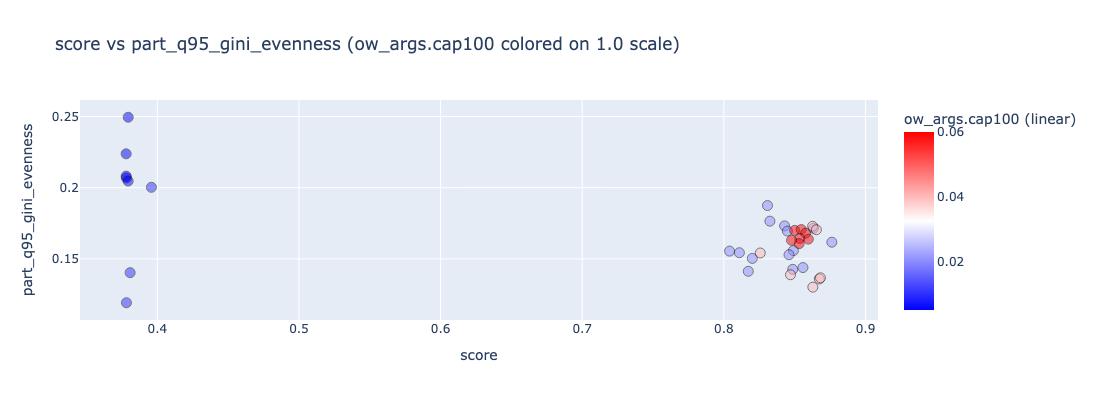

In [36]:
import numpy as np, pandas as pd, plotly.express as px

df = pd.DataFrame(consolidated_data)

# # --- get R2 robustly (don't parse from /Users/...) ---
# if "R2" in df.columns:
#     df["R2"] = pd.to_numeric(df["R2"], errors="coerce")
# elif "folder" in df.columns:
#     df["R2"] = pd.to_numeric(df["folder"].astype(str).str.extract(r"^([0-9\.]+)")[0], errors="coerce")
# else:
#     df["R2"] = pd.to_numeric(
#         df["path"].astype(str).str.extract(r"(?:^|[^A-Za-z0-9])R2(?:=|_|-)([0-9]*\.?[0-9]+)")[0],
#         errors="coerce"
#     )
df = df.rename(columns=lambda c: f"{c[0]}_{c[1]}" if isinstance(c, tuple) else str(c))
df = df.dropna(subset=["R2"])
df = df[df["R2"] > 0.5]
df = df[df["experiment_folder"].isin([
    # "CDDM_SparsityAndFRMag-ab-77398e_BaseTrainer",
    # "CDDM_RecurrentWeightMagnitude-c21be0_BaseTrainer"
    # "CDDM_HMagnitudeOnly-c21be0_BaseTrainer",
    'CDDM_OutputWeightMagnitude-c21be0_BaseTrainer'
    # "CDDM_BareTraining-794a7f3_BaseTrainer",
    # 'CDDM_PositiveBiasesOnly02-1020a33_BaseTrainer'
])]


column = "ow_args.cap100"
scale = "linear"  # "linear" or "log" (only applies when numeric)

raw = df[column]
num = pd.to_numeric(raw, errors="coerce")
is_numeric = num.notna().sum() == raw.notna().sum()

scale = 1.  # used for marker sizing/layout
x = 'score'
y = "part_q95_gini_evenness"
if is_numeric:
    df[column] = num

    if scale == "log":
        df = df[df[column] > 0]
        color_col = f"{column}_log10"
        df[color_col] = np.log10(df[column].to_numpy())

        vmin, vmax = df[column].min(), df[column].max()
        decades = np.arange(np.floor(np.log10(vmin)), np.ceil(np.log10(vmax)) + 1)
        ticks = np.power(10.0, decades)
        tickvals = np.log10(ticks)
        ticktext = [f"{t:g}" for t in ticks]
        cbar_title = f"{column} (log10 scale)"
    else:
        color_col = column
        tickvals, ticktext = None, None
        cbar_title = f"{column} (linear)"

    cmin, cmax = float(df[color_col].min()), float(df[color_col].max())
    cmid = 0.5 * (cmin + cmax)
    fig = px.scatter(
        df, x=x, y=y,
        color=color_col,
        color_continuous_scale=[(0, "blue"), (0.5, "white"), (1, "red")],
        color_continuous_midpoint=cmid,
        range_color=(cmin, cmax),
        hover_data=df.columns,
        title=f"{x} vs {y} ({column} colored on {scale} scale)"
    )
    fig.update_layout(coloraxis_colorbar=dict(title=cbar_title, tickvals=tickvals, ticktext=ticktext))

else:
    cat_col = f"{column}_str"
    df[cat_col] = raw.astype(str).fillna("NA")

    order = sorted(pd.unique(df[cat_col]), key=lambda s: (s == "NA", s))
    seq = distinct_hex_colors(len(order), seed=0)
    color_map = dict(zip(order, seq))

    hover_col = "experiment_folder"  # or "folder" if that’s what you want shown
    fig = px.scatter(
        df, x=x, y=y,
        color=cat_col if not is_numeric else color_col,
        hover_name=hover_col,
        hover_data={"path": False, "N": True, x: True, y: True, "max_iter": True},  # optional extras; delete if you want minimal
        category_orders={cat_col: order} if not is_numeric else None,
        color_discrete_map=color_map if not is_numeric else None,
        color_continuous_scale=[(0, "blue"), (0.5, "white"), (1, "red")] if is_numeric else None,
        title=f"{x} vs {y}"
    )
    fig.update_layout(legend_title_text=column)

fig.update_layout(autosize=False, width=800 * scale, height=400 * scale)
fig.update_traces(marker=dict(opacity=0.5, size=10 * scale, line=dict(width=1, color="black")))
fig.write_image(f"statistics_{x}_vs_{y}.svg")
fig.show()


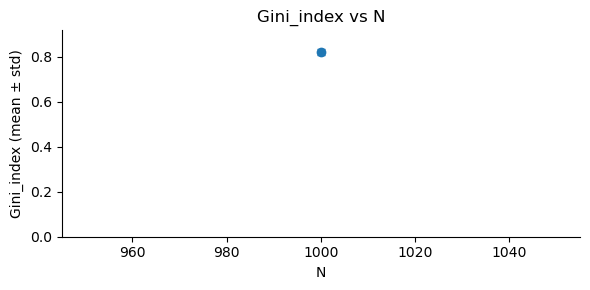

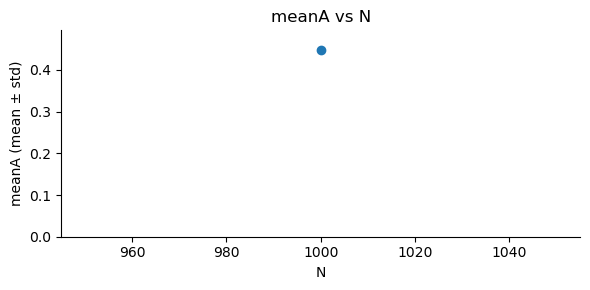

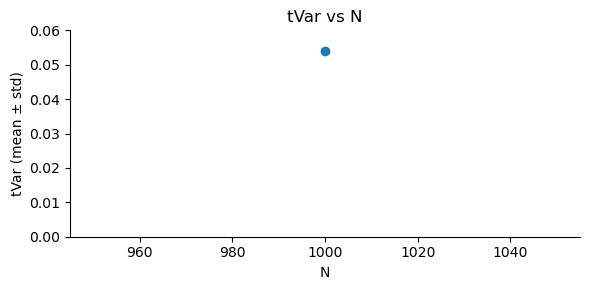

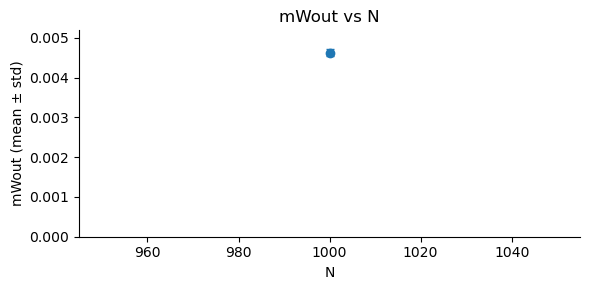

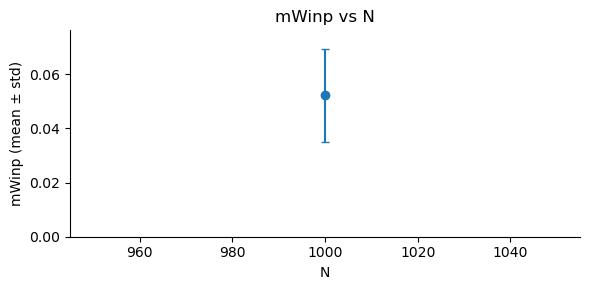

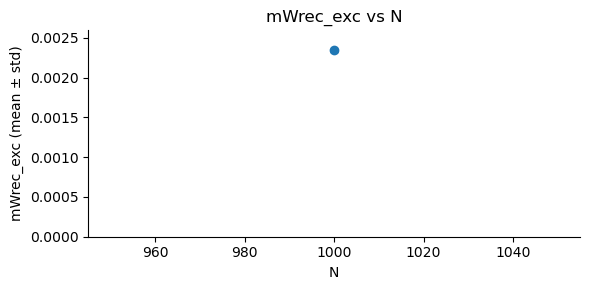

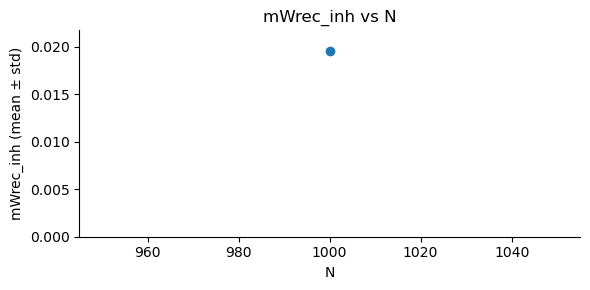

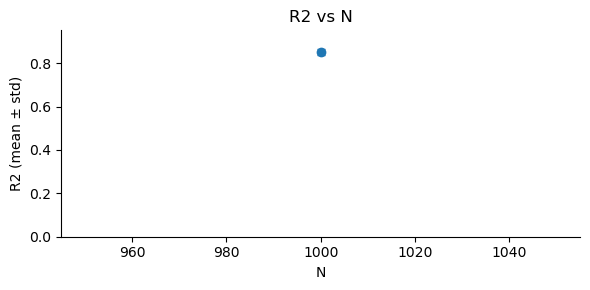

In [36]:
for col in ['Gini_index', 'meanA', 'tVar', 'mWout', 'mWinp', 'mWrec_exc', 'mWrec_inh', 'R2']:
    g = df.groupby('N')[col].agg(['mean','var','count']).reset_index().sort_values('N')
    x   = g['N'].to_numpy()
    y   = g['mean'].to_numpy()
    err = np.sqrt(g['var'].to_numpy())               # std
    # if ~np.isnan(err).any():
        # err = err / np.sqrt(g['count'].to_numpy())     # <- use this for SEM instead
        
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.errorbar(x, y, yerr=err, fmt='-o', capsize=3)
    ax.set_xlabel('N')
    ax.set_ylabel(f'{col} (mean ± std)')
    ax.set_title(f'{col} vs N')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim([0, np.nanmax(y + err)*1.1])
    fig.tight_layout()
    plt.savefig(f"{col}_SE_networks.svg", bbox_inches='tight', dpi=300) 
    plt.show()


In [ ]:
col = 'meanA'
g = df.groupby('N')[col].agg(['mean','var','count']).reset_index().sort_values('N')
x   = g['N'].to_numpy()
y   = g['mean'].to_numpy()
err = np.sqrt(g['var'].to_numpy())               # std
# if ~np.isnan(err).any():
    # err = err / np.sqrt(g['count'].to_numpy())     # <- use this for SEM instead

fig, ax = plt.subplots(figsize=(6, 3))
ax.errorbar(x, y, yerr=err, fmt='-o', capsize=3)
z = 0.7 * np.log(100) / np.log(x)
ax.plot(x, z)
ax.set_xlabel('N')
ax.set_ylabel(f'{col} (mean ± std)')
ax.set_title(f'{col} vs N')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([0, np.nanmax(y + err)*1.1])
fig.tight_layout()
plt.show()


In [ ]:
col = 'mWout'
g = df.groupby('N')[col].agg(['mean','var','count']).reset_index().sort_values('N')
x   = g['N'].to_numpy()
y   = g['mean'].to_numpy()
err = np.sqrt(g['var'].to_numpy())               # std
# if ~np.isnan(err).any():
    # err = err / np.sqrt(g['count'].to_numpy())     # <- use this for SEM instead
fig, ax = plt.subplots(figsize=(6, 3))
ax.errorbar(x, y, yerr=err, fmt='-o', capsize=3)
# ax.errorbar(x, y*z, color='r')
ax.set_xlabel('N')
ax.set_ylabel(f'{col} (mean ± std)')
ax.set_title(f'{col} vs N')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([0, np.max(y + err)*1.1])
fig.tight_layout()
plt.show()